In [1]:
import sys
sys.path.append('../')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['TORCH_HOME'] = '/home/jovyan/.cache/torch/'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import visualize
from utils import pickle_load, pickle_save
from utils import get_bdd_paths, get_camvid_paths
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
# segmentation models wrapper
from segmodel import SegModel
# anomaly detection functions
from anomaly_detection import sample_selection_function
# datasets wrapper
from dataset import CamVid, BDD100K
from datetime import datetime

In [2]:
MAX_QUEERY_IMAGES = 120 # 220 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 1 # 5 # number of epochs to train a model during one AL cicle
BATCH_SIZE = 16 #! should be 8 for DeepLab training
INITIAL_LR = 1e-4
INITIAL_N_TRAIN_IMAGES = 20 # 20, initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [20] #, 100] # k: number of uncertain images to label at each AL cicle
SEMSEG_CLASSES = ['road', 'car']
SAMPLES_SELECTIONS = ['Random', 'Committee']
VISUALIZE_UNCERTAIN = True
VERBOSE_TRAIN = True
ENSEMBLE_SIZE = 3

In [3]:
# get the data
DATASET = CamVid # BDD100K or CamVid

# Load data
if DATASET == CamVid:
    X_train_paths, y_train_paths, X_valid_paths, y_valid_paths = get_camvid_paths(path='/home/ruslan/datasets/CamVid/')
elif DATASET == BDD100K:
    X_train_paths, y_train_paths, X_valid_paths, y_valid_paths = get_bdd_paths(path='/home/ruslan/datasets/bdd100k/seg/')
else:
    print('Choose DATASET_TYPE="CamVid" or "BDD100K"')

In [4]:
def al_experiment(models,
                  k,
                  samples_selection_name='Random',
                  experiment_name='AL_experiment',
                  visualize_most_uncertain=False,
                  verbose_train=False,
                  random_seed=1):
    # tensorboard
    dt = datetime.now().strftime("%A, %d. %B %Y %I:%M%p") # date time
    tb = SummaryWriter(log_dir=f'tb_runs/AL_experiment_{dt}/{experiment_name}')
    
    # choose first data batch to train on
    np.random.seed(random_seed)
    X_pull = np.copy(X_train_paths)
    y_pull = np.copy(y_train_paths)
    
    initial_selection = np.random.choice(len(X_pull), INITIAL_N_TRAIN_IMAGES, replace=False) # k
    X_train_paths_part = X_pull[initial_selection]
    y_train_paths_part = y_pull[initial_selection]

    X_test = np.delete(X_pull, initial_selection)
    y_test = np.delete(y_pull, initial_selection)
    
    samples_selection_fn = sample_selection_function(samples_selection_name)
    
    IoUs = [0.]
    N_train_samples = [0]
    # main AL loop
    while len(X_train_paths_part) <= MAX_QUEERY_IMAGES:
        # train each model in committee
        print('Labelled set size: ', len(X_train_paths_part))
        print('Unlabelled set size: ', len(X_test))
        for model in models:
            print(f'\nTraining a model for {model.epochs} epochs...')
            model.train(X_train_paths_part,
                        y_train_paths_part,
                        X_valid_paths,
                        y_valid_paths,
                        Dataset=DATASET,
                        verbose=verbose_train)
        # remeber results
        val_iou = np.mean([model.max_val_iou_score for model in models])
        max_val_iou = np.max([model.max_val_iou_score for model in models])
        print(f'IoU so far: {val_iou}')
        IoUs.append(val_iou)
        N_train_samples.append(len(X_train_paths_part))

        train_iou = np.mean([model.max_train_iou_score for model in models])
        max_train_iou = np.max([model.max_train_iou_score for model in models])
        tb.add_scalar('Mean Ensemble Train IoU vs N train images', train_iou, len(X_train_paths_part))
        tb.add_scalar('Mean Ensemble Valid IoU vs N train images', val_iou, len(X_train_paths_part))
        tb.add_scalar('Max Ensemble Train IoU vs N train images', max_train_iou, len(X_train_paths_part))
        tb.add_scalar('Max Ensemble Valid IoU vs N train images', max_val_iou, len(X_train_paths_part))
        
        if len(X_test) < k:
            print('\nNo more images in Unlabelled set')
            break

        # select most uncertain samples
        selected_images_indexes = samples_selection_fn(X_test, k, models)

        # Visualization
        if visualize_most_uncertain and samples_selection_name!='Random':
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                for model in models:
                    pr_mask = model.predict([img_path])
                    mask_np = pr_mask.squeeze().cpu().numpy().round()
                    
                    plt.figure(figsize=(16, 5))
                    title = f'{model.name}_{model.encoder}_N_train_{len(X_train_paths_part)}'
                    print(title)
                    plt.title(title)
                    visualize(image=image, road_mask=mask_np[0,...], car_mask=mask_np[1,...])
                    plt.show()

        # Add labels for uncertain images to train data
        #print('Labelled set before: ', len(X_train_paths_part))
        X_train_paths_part = np.concatenate([X_train_paths_part, X_test[selected_images_indexes]])
        y_train_paths_part = np.concatenate([y_train_paths_part, y_test[selected_images_indexes]])
        #print('Labelled set after: ', len(X_train_paths_part))

        # Remove labelled data from validation set
        #print('Unlabelled set before: ', len(X_test))
        X_test = np.delete(X_test, selected_images_indexes)
        y_test = np.delete(y_test, selected_images_indexes)
        #print('Unlabelled set after: ', len(X_test))

    print(f'Max IoU score: {np.max(IoUs)}')
    print('----------------------------------------\n')
    return IoUs, N_train_samples

In [5]:
def models_ensemble(n_models=4):
    model1 = SegModel('Unet', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)
    model2 = SegModel('FPN', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)
    model3 = SegModel('PAN', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)
    model4 = SegModel('DeepLabV3', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)

    models = [model1, model2, model3, model4]
    models = models[:n_models]
    for model in models:
        model.epochs = MODEL_TRAIN_EPOCHS
        model.batch_size = BATCH_SIZE
        model.learning_rate = INITIAL_LR
    return models


Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  347

Training a model for 1 epochs...
Creating new model: Unet_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 80.01it/s, dice_loss - 0.6967, iou_score - 0.006026]
Model saved!

Training a model for 1 epochs...
Creating new model: FPN_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 82.19it/s, dice_loss - 0.238, iou_score - 0.6846] 
Model saved!

Training a model for 1 epochs...
Creating new model: PAN_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 74.25it/s, dice_loss - 0.788, iou_score - 0.0598]  
Model saved!
IoU so far: 0.250157723507595
Labelled set size:  40
Unlabelled set size:  327

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01

  0%|          | 0/347 [00:00<?, ?it/s]

IoU so far: 0.24570120942376242
Models in ensemble: 1
Inference on unlabelled data...


100%|██████████| 347/347 [00:16<00:00, 21.06it/s]


Min Vote entropy: 0.530,             Mean Vote entropy: 1.028,             Max Vote entropy: 1.242
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_20


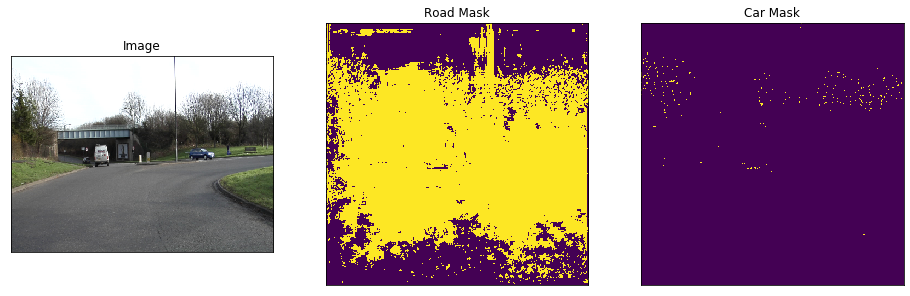

FPN_mobilenet_v2_N_train_20


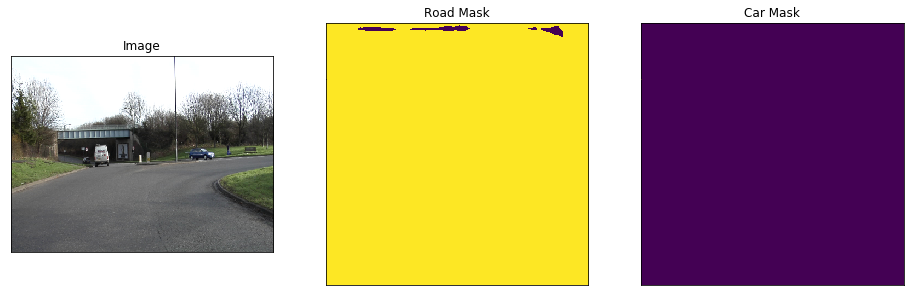

PAN_mobilenet_v2_N_train_20


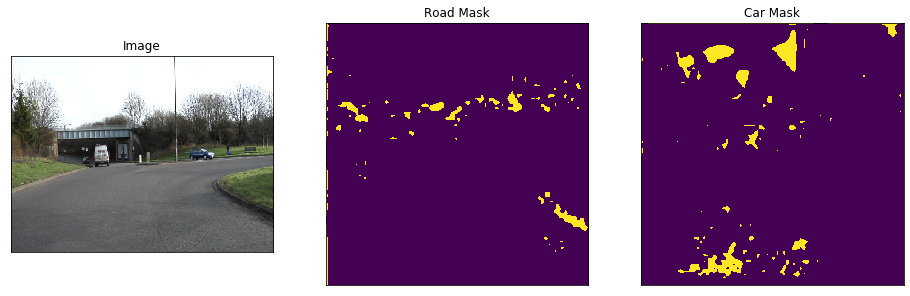

Labelled set size:  40
Unlabelled set size:  327

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 82.79it/s, dice_loss - 0.6715, iou_score - 0.1656]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 88.32it/s, dice_loss - 0.5262, iou_score - 0.3139]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 79.27it/s, dice_loss - 0.4189, iou_score - 0.4783]
Model saved!


  0%|          | 0/327 [00:00<?, ?it/s]

IoU so far: 0.3192597752062008
Models in ensemble: 1
Inference on unlabelled data...


100%|██████████| 327/327 [00:14<00:00, 21.84it/s]


Min Vote entropy: 0.566,             Mean Vote entropy: 0.825,             Max Vote entropy: 1.121
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_40


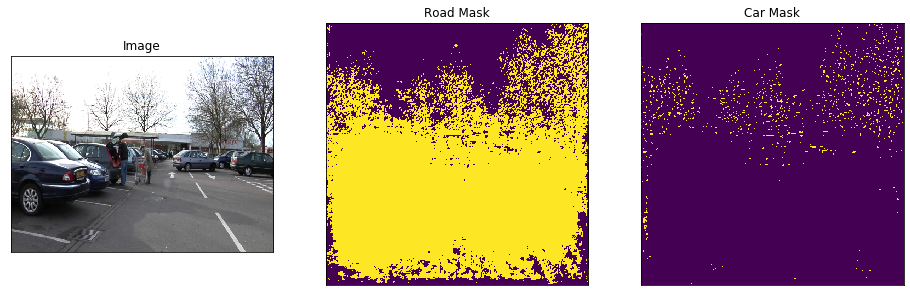

FPN_mobilenet_v2_N_train_40


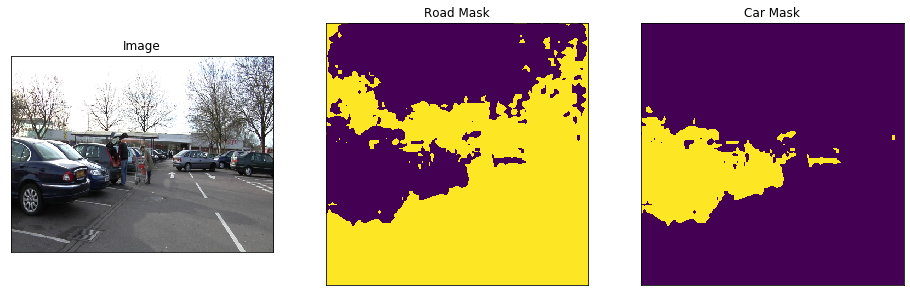

PAN_mobilenet_v2_N_train_40


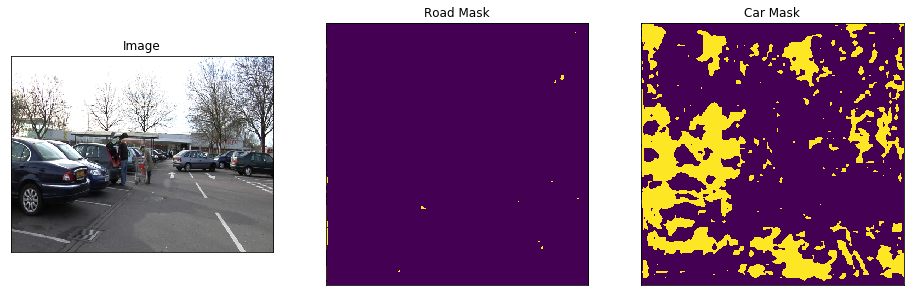

Labelled set size:  60
Unlabelled set size:  307

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 81.77it/s, dice_loss - 0.5896, iou_score - 0.2211]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 89.47it/s, dice_loss - 0.1311, iou_score - 0.7723]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 78.95it/s, dice_loss - 0.364, iou_score - 0.5359]
Model saved!


  0%|          | 0/307 [00:00<?, ?it/s]

IoU so far: 0.5097578336106668
Models in ensemble: 2
Inference on unlabelled data...


100%|██████████| 307/307 [00:25<00:00, 12.17it/s]


Min Vote entropy: 0.345,             Mean Vote entropy: 0.699,             Max Vote entropy: 0.907
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_60


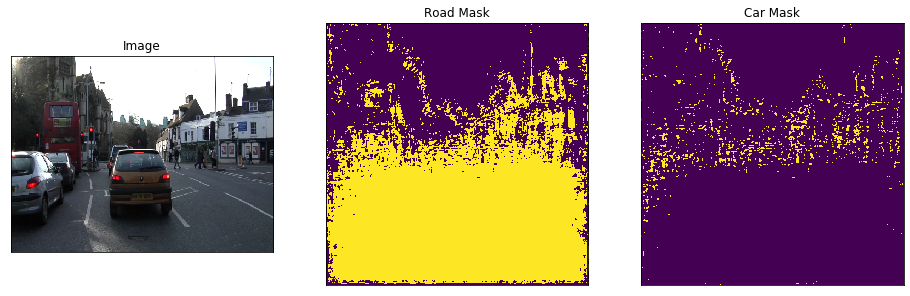

FPN_mobilenet_v2_N_train_60


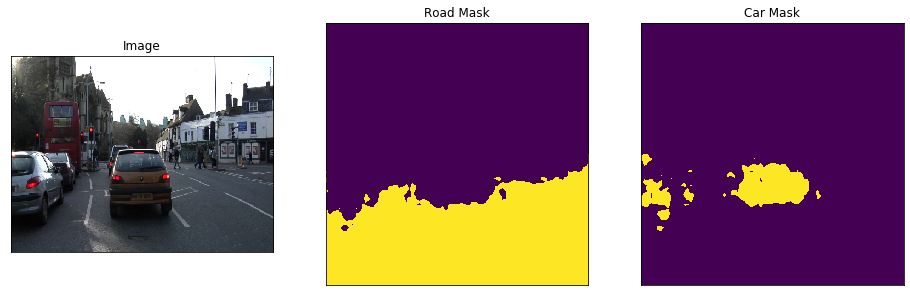

PAN_mobilenet_v2_N_train_60


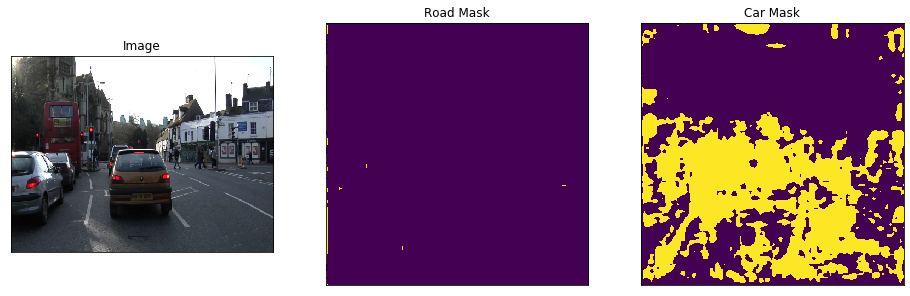

Labelled set size:  80
Unlabelled set size:  287

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 82.04it/s, dice_loss - 0.5248, iou_score - 0.3245]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 86.33it/s, dice_loss - 0.1046, iou_score - 0.8148]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 79.17it/s, dice_loss - 0.2401, iou_score - 0.7412]
Model saved!


  0%|          | 0/287 [00:00<?, ?it/s]

IoU so far: 0.6268467119227934
Models in ensemble: 2
Inference on unlabelled data...


100%|██████████| 287/287 [00:23<00:00, 12.06it/s]


Min Vote entropy: 0.239,             Mean Vote entropy: 0.587,             Max Vote entropy: 0.771
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_80


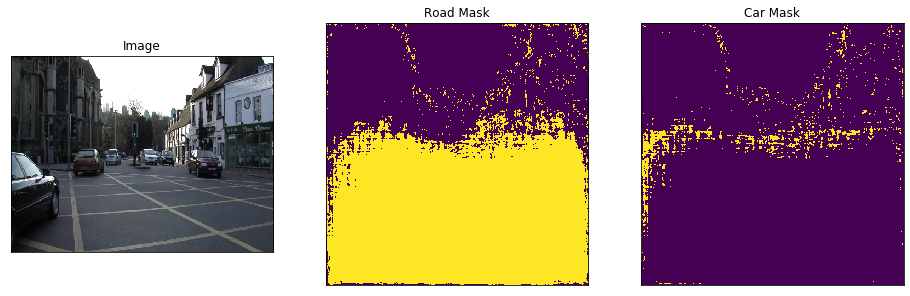

FPN_mobilenet_v2_N_train_80


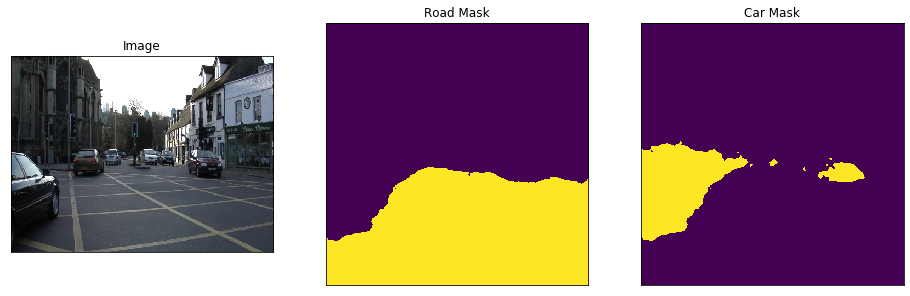

PAN_mobilenet_v2_N_train_80


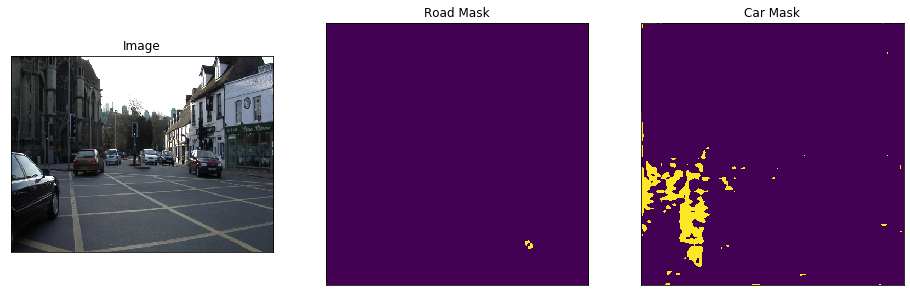

Labelled set size:  100
Unlabelled set size:  267

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 81.17it/s, dice_loss - 0.3373, iou_score - 0.6996]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 87.82it/s, dice_loss - 0.1048, iou_score - 0.8127]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 77.52it/s, dice_loss - 0.153, iou_score - 0.7725]
Model saved!


  0%|          | 0/267 [00:00<?, ?it/s]

IoU so far: 0.7615774399769971
Models in ensemble: 3
Inference on unlabelled data...


100%|██████████| 267/267 [00:33<00:00,  7.88it/s]


Min Vote entropy: 0.426,             Mean Vote entropy: 0.568,             Max Vote entropy: 0.782
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_100


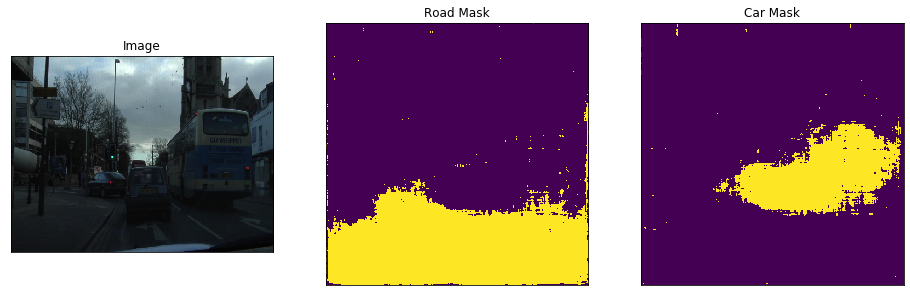

FPN_mobilenet_v2_N_train_100


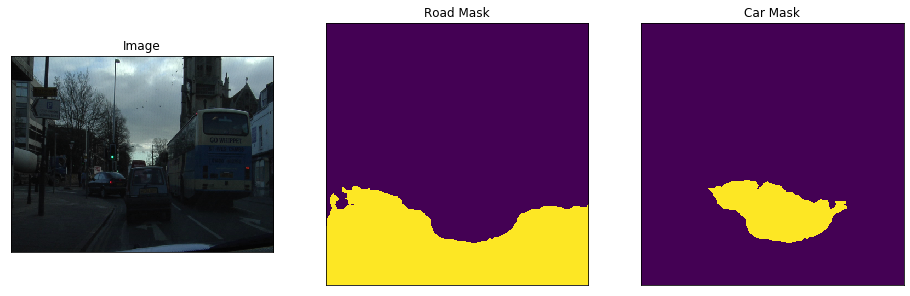

PAN_mobilenet_v2_N_train_100


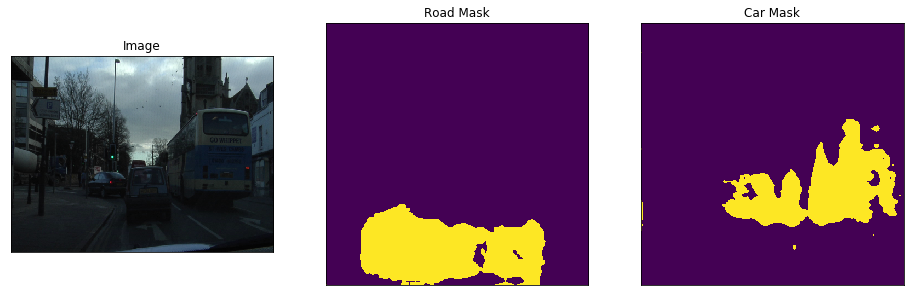

Labelled set size:  120
Unlabelled set size:  247

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 76.11it/s, dice_loss - 0.2772, iou_score - 0.7656]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 86.42it/s, dice_loss - 0.05681, iou_score - 0.8985]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:01<00:00, 76.15it/s, dice_loss - 0.1347, iou_score - 0.7834]
Model saved!


  0%|          | 0/247 [00:00<?, ?it/s]

IoU so far: 0.8158194139452264
Models in ensemble: 3
Inference on unlabelled data...


100%|██████████| 247/247 [00:31<00:00,  7.95it/s]


Min Vote entropy: 0.354,             Mean Vote entropy: 0.453,             Max Vote entropy: 0.584
Visualizing most uncertain results so far:
Unet_mobilenet_v2_N_train_120


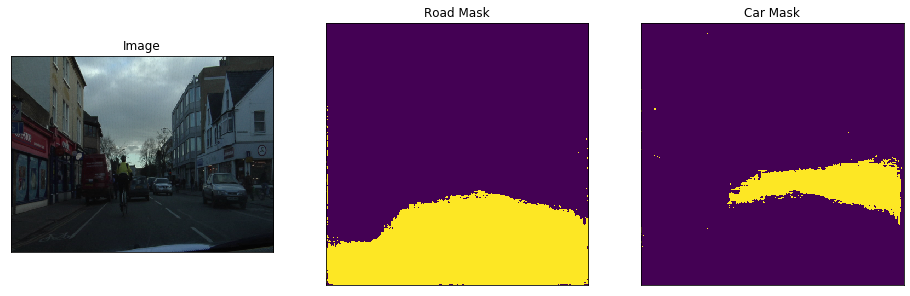

FPN_mobilenet_v2_N_train_120


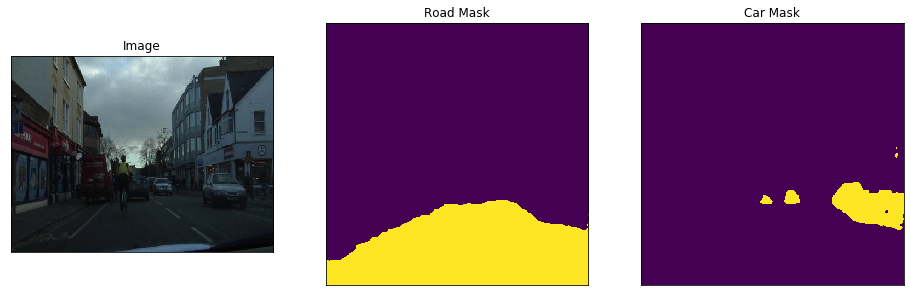

PAN_mobilenet_v2_N_train_120


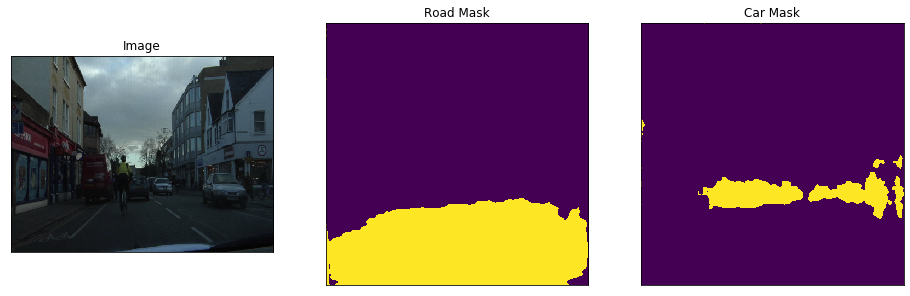

Max IoU score: 0.8158194139452264
----------------------------------------

saved results.pkl


In [6]:
results = {}

# choose samples selection function
for samples_selection_name in SAMPLES_SELECTIONS:
    print(f'\nSamples selection function: {samples_selection_name}')
    print('------------------------------------')
    results[samples_selection_name] = {}
    
    # choose number of samples to select for labelling from inference results
    for k in NUM_UNCERTAIN_IMAGES:
        print(f'\nNumber of samples to label on one iteration, k={k}')
        print('------------------------------------')

        # define models committee
        models = models_ensemble(n_models=ENSEMBLE_SIZE)
            
        results[samples_selection_name][str(k)] = {}

        experiment_name = f'{samples_selection_name}_{k}'
        IoUs, N_train_samples = al_experiment(models,
                                      k,
                                      samples_selection_name,
                                      experiment_name,
                                      visualize_most_uncertain=VISUALIZE_UNCERTAIN,
                                      verbose_train=VERBOSE_TRAIN)
        
        results[samples_selection_name][str(k)]['IoUs'] = IoUs
        results[samples_selection_name][str(k)]['N_train_samples'] = N_train_samples
        
pickle_save('results.pkl', results)

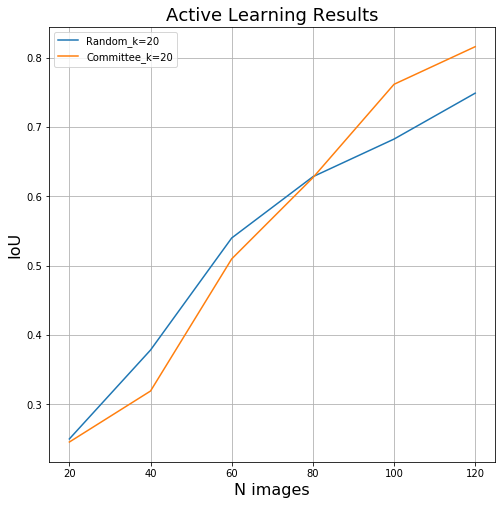

In [7]:
results = pickle_load('results.pkl')

plt.figure(figsize=(8,8))

# choose samples selection function
for samples_selection_name in SAMPLES_SELECTIONS:        
    # choose number of samples to select for labelling from inference results
    for k in NUM_UNCERTAIN_IMAGES:

        ious = results[samples_selection_name][str(k)]['IoUs']
        n_train = results[samples_selection_name][str(k)]['N_train_samples']
        
        plt.plot(np.array(n_train[1:]), ious[1:], label=f'{samples_selection_name}_k={k}')

plt.grid()
plt.title('Active Learning Results', fontsize=18)
plt.xlabel('N images', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.legend()
plt.savefig('results.png');